In [1]:
import os
import re
import pickle
import numpy as np
from mne import viz
from scipy import io
from matplotlib import colors, pyplot as plt
from sklearn import model_selection, ensemble, svm, discriminant_analysis, neural_network, linear_model, metrics

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

CLASSIFIERS = ['SVM', 'LDA', 'RandomForest', 'MultilayerPerceptron']

FEATURE_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\Features{dose}\\Combined'.format(dose=CAF_DOSE)
PROJECT_PATH = '..\\data'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(FEATURE_PATH, 'data_avg.pickle'), 'rb') as file:
    data = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'labels_avg.pickle'), 'rb') as file:
    labels = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'groups_avg.pickle'), 'rb') as file:
    groups = pickle.load(file)

In [5]:
scores = {}
for stage in STAGES:
    scores[stage] = {}
    
    features = [feature for name, feature in data[stage].items() if not 'SpecPermEn' in name]
    print(f'{stage}: Training on {len(features)} features, {len(features[0])} samples')
    
    x_all = np.concatenate(features, axis=1)
    y = labels[stage]
    g = groups[stage]
    
    curr_ensemble = []
    curr_testing = []
    
    for clf_name in CLASSIFIERS:
        scores[stage][clf_name] = []
        curr_ensemble.append([])
        curr_testing.append([])
        
        for electrode in range(20):
            print(f'    {clf_name} on electrode {electrode + 1}:', end='')
            
            if clf_name.lower() == 'svm':
                clf = svm.SVC
                params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3], 'gamma': ['auto', 'scale']}
            elif clf_name.lower() == 'lda':
                clf = discriminant_analysis.LinearDiscriminantAnalysis
                params = {'solver': ['svd', 'lsqr', 'eigen']}
            elif clf_name.lower() == 'multilayerperceptron':
                clf = neural_network.MLPClassifier
                params = {'max_iter': [2000], 'hidden_layer_sizes': [(8,), (4,)], 'activation': ['relu'], 'learning_rate': ['constant']}
            elif clf_name.lower() == 'randomforest':
                clf = ensemble.RandomForestClassifier
                params = {'n_jobs': [-1], 'n_estimators': [15, 30], 'max_depth': [10, None], 'max_features': ['sqrt', 'log2']}
                
            x = x_all[:,electrode::20]

            # randomly take half of the subjects away for the grid search
            half_out = model_selection.LeavePGroupsOut(n_groups=len(np.unique(groups[stage])) // 2)
            train_indices, test_indices = next(half_out.split(x, y, g))
            x_train, y_train, g_train = x[train_indices], y[train_indices], g[train_indices]
            
            # use KFold cross validation in the grid search
            grid_kfold = model_selection.GroupKFold(n_splits=len(np.unique(g)) // 2)
            grid_search = model_selection.GridSearchCV(estimator=clf(),
                                                       param_grid=params,
                                                       iid=True,
                                                       cv=grid_kfold.split(x_train, y_train, g_train),
                                                       n_jobs=-1)
            grid_search.fit(x_train, y_train, g_train)
            
            print(f' params: {grid_search.best_params_}', end='')
            
            kfold = model_selection.GroupKFold(n_splits=10)
            split = list(kfold.split(x, y, groups[stage]))
            test_indices = [indices[1] for indices in split]
            
            current = model_selection.permutation_test_score(estimator=clf(**grid_search.best_params_),
                                                             X=x,
                                                             y=y,
                                                             groups=groups[stage],
                                                             cv=split,
                                                             n_permutations=1000,
                                                             n_jobs=-1)
            
            print(f' score: {current[0]:.3f}, p={current[2]:.3f}')
            scores[stage][clf_name].append(current[::2])
            curr_ensemble[-1].append(grid_search.best_estimator_)
            curr_testing[-1].append(test_indices)
        print()
    
    scores[stage]['ensemble'] = []
    for electrode in range(20):
        clfs = [curr[electrode] for curr in curr_ensemble]
        test_folds = [curr[electrode] for curr in curr_testing][0]
        
        x = x_all[:,electrode::20]
        
        accuracies = []
        for fold in test_folds:
            preds = np.rint(np.mean([curr.predict(x[fold]) for curr in clfs], axis=0)).astype(int)
            accuracies.append(metrics.accuracy_score(preds, y[fold]))
        
        scores[stage]['ensemble'].append((np.mean(accuracies), 1))
    print('Ensemble accuracies:', [score[0] for score in scores[stage]['ensemble']], '\n')
    
    with open(os.path.join('..', 'results', f'scores{CAF_DOSE}', f'scores_multi_{stage}.pickle'), 'wb') as file:
        pickle.dump(scores[stage], file)

AWSL: Training on 10 features, 76 samples
    SVM on electrode 1: params: {'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'} score: 0.512, p=0.438
    SVM on electrode 2: params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} score: 0.517, p=0.342
    SVM on electrode 3: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.554, p=0.175
    SVM on electrode 4: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.579, p=0.060
    SVM on electrode 5: params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} score: 0.537, p=0.087
    SVM on electrode 6: params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'} score: 0.546, p=0.230
    SVM on electrode 7: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} score: 0.542, p=0.220
    SVM on electrode 8: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.558, p=0.118
    SVM on electrode 9: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} score: 0.529, p=0.276
    SVM on electrode 

    SVM on electrode 5: params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly'} score: 0.512, p=0.442
    SVM on electrode 6: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'} score: 0.500, p=0.557
    SVM on electrode 7: params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} score: 0.487, p=0.779
    SVM on electrode 8: params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} score: 0.487, p=0.805
    SVM on electrode 9: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.550, p=0.074
    SVM on electrode 10: params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly'} score: 0.537, p=0.070
    SVM on electrode 11: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.550, p=0.090
    SVM on electrode 12: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'} score: 0.537, p=0.218
    SVM on electrode 13: params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} score: 0.487, p=0.700
    SVM on electrode 14: params: {'degree': 2, 'gamma': 'auto'

IndexError: tuple index out of range

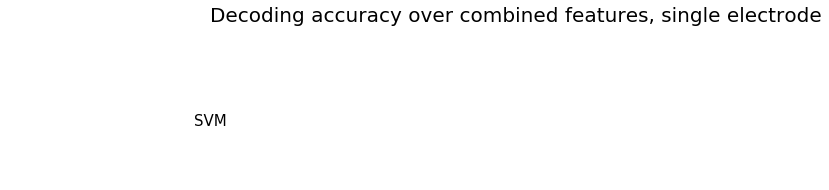

In [6]:
colormap = 'coolwarm'

plt.figure(figsize=(18, 5))
plt.suptitle('Decoding accuracy over combined features, single electrode', y=1.1, fontsize=20)

all_scores = [[[score[0] for score in scores[stage][clf_name]] for clf_name in scores[stage].keys() if not clf_name == 'ensemble'] for stage in STAGES]
vmin = min(np.min(all_scores), np.min([scores[stage]['ensemble'] for stage in STAGES]))
vmax = max(np.max(all_scores), np.max([scores[stage]['ensemble'] for stage in STAGES]))

axes = []
subplot_index = 1
for clf_name in scores[STAGES[0]].keys():
    axes.append(plt.subplot(len(scores), 4, subplot_index))
    plt.annotate(clf_name, xy=(0.75, 0.5), fontsize=15)
    plt.axis('off')
    subplot_index += 1
    
    for stage in STAGES:
        if clf_name == 'ensemble':
            curr_acc = scores[stage][clf_name]
            curr_sig = np.ones(20)
        else:
            curr_acc = np.array([score[0] for score in scores[stage][clf_name]])
            curr_sig = np.array([score[2] for score in scores[stage][clf_name]])

        axes.append(plt.subplot(len(scores), 4, subplot_index))
        if subplot_index <= 4:
            plt.title(stage, fontsize=15)
        mask = curr_sig < SIGNIFICANT_P
        viz.plot_topomap(curr_acc, sensor_pos, mask=mask, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
        subplot_index += 1

norm = colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, shrink=1, aspect=10)
plt.savefig(f'..\\results\\figures{CAF_DOSE}\\combined_multi_DA.png')
plt.show()